In [264]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [265]:
rndr_df = pd.read_csv('./data/RNDR_historical_data.csv')

In [266]:
# Armazenando a coluna de datas separadamente
dates = rndr_df['date']

In [267]:
print(dates)

0      2023-09-16
1      2023-09-17
2      2023-09-18
3      2023-09-19
4      2023-09-20
          ...    
360    2024-09-10
361    2024-09-11
362    2024-09-12
363    2024-09-13
364    2024-09-14
Name: date, Length: 365, dtype: object


In [268]:
# Removendo a coluna de datas antes de normalizar
rndr_df = rndr_df.drop(columns=['date'])

In [269]:
# Normalizando os dados numéricos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rndr_df)

In [270]:
# Normalizando apenas a coluna de preços (durante o treino e o teste)
scaler = MinMaxScaler(feature_range=(0, 1))

In [271]:
scaled_data = scaler.fit_transform(rndr_df[['price']].values)

In [272]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [273]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [298]:
# Exibindo os valores preditos
print(train_predict[:5])  # Exibe as primeiras 5 previsões reais
print(test_predict[:5])   # Exibe as primeiras 5 previsões reais

[[33.452465]
 [33.273876]
 [33.84245 ]
 [34.887665]
 [36.119804]]
[[66.90222 ]
 [65.05467 ]
 [63.86702 ]
 [62.214806]
 [61.191784]]


In [275]:
# Criar os dados de treinamento
train_size = int(len(rndr_df) * 0.8)
test_size = len(rndr_df) - train_size

train_data = rndr_df[:train_size]
test_data = rndr_df[train_size:]

In [276]:
def create_dataset(rndr_df, time_step):
    X, y = [], []
    for i in range(len(rndr_df) - time_step - 1):
        # Ajustando a indexação usando pandas .iloc
        X.append(rndr_df.iloc[i:(i + time_step), 0].values)  # .values para retornar um array NumPy
        y.append(rndr_df.iloc[i + time_step, 0])
    return np.array(X), np.array(y)

In [277]:
# Criando dados de entrada e saída para treinamento e teste
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [278]:
# Redimensionar para LSTM [amostras, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [279]:
# Definindo a forma de entrada
input_shape = (X_train.shape[1], 1)

In [280]:
# Construindo o modelo LSTM
model = Sequential()

In [281]:
# Adicionando a entrada explicitamente com a camada Input()
model.add(Input(shape=input_shape))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

In [282]:
# Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [283]:
# Treinando o modelo
model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 49.7024
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 15.6059
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8.3603
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 9.7296 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 6.7947
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.1400
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.5342
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.0846
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.7644
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.7455
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.7752
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.0472
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1254
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1510
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.1470
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━

In [284]:
# Fazendo previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [285]:
y_train_reshaped = y_train.reshape(-1, 1)

In [286]:
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train_reshaped)

In [287]:
y_test_reshaped = y_test.reshape(-1, 1)

In [288]:
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test_reshaped)

In [289]:
sequence_length = 1

In [290]:
adjusted_index = rndr_df.index[sequence_length:sequence_length + len(y_train)]

In [306]:
train_dates = train_dates[-len(y_train):]  # Para o conjunto de treino
test_dates = dates[-len(y_test):]   # Para o conjunto de teste

train_dates = pd.to_datetime(train_dates)
test_dates = pd.to_datetime(test_dates)

In [308]:
train_predict = scaler.transform(train_predict)
test_predict = scaler.transform(test_predict)

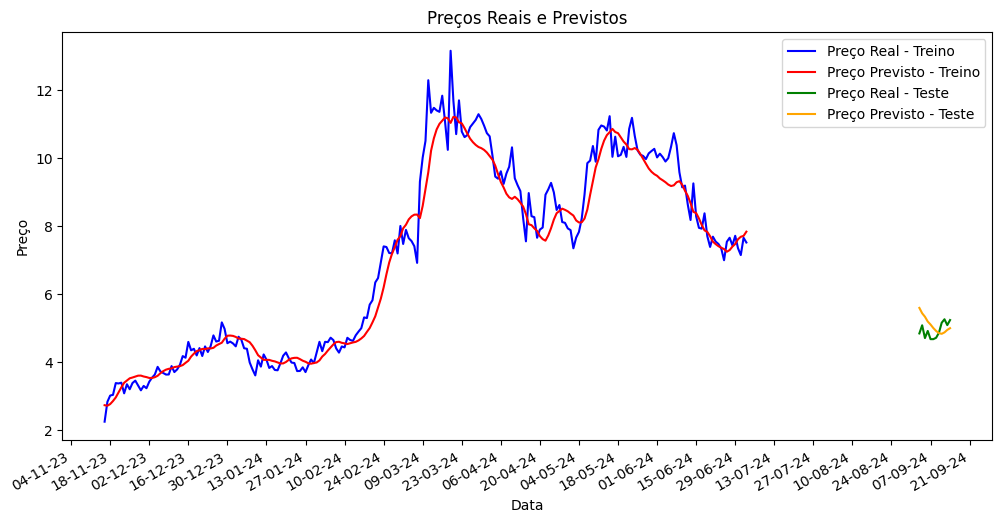

In [317]:
plt.figure(figsize=(12, 6))

# Preço Real - Treino
plt.plot(train_dates, y_train[:, 0], color='blue', label='Preço Real - Treino')

# Preço Previsto - Treino
plt.plot(train_dates, train_predict[:, 0], color='red', label='Preço Previsto - Treino')

# Ajuste para os dados de teste
adjusted_test_index = rndr_df.index[train_size + sequence_length:train_size + sequence_length + len(y_test)]

# Preço Real - Teste
plt.plot(test_dates, y_test[:, 0], color='green', label='Preço Real - Teste')

# Preço Previsto - Teste
plt.plot(test_dates, test_predict[:, 0], color='orange', label='Preço Previsto - Teste')

# Formatando as datas para melhor visualização
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))

# Exibindo o gráfico
plt.title('Preços Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()